In [14]:
import os
from glob import glob
from ipywidgets import IntProgress
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import regularizers

import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility
seed = 36
tf.random.set_seed(seed)
np.random.seed(seed)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Notes

## STFT window size
https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft

n_fft = length of the windowed signal after padding with zeros. The number of rows in the STFT matrix D is (1 + n_fft/2). **The default value, n_fft=2048 samples**, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for **music signals**. However, in **speech processing, the recommended value is 512**, corresponding to 23 milliseconds at a sample rate of 22050 Hz. In any case, we recommend setting n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.

## Preprocessing decisions:
(UPDATE)

1. Do not trim leading and trailing silence from an audio signal (below 20 db is considered as silence)
2. Cut signal to a specified duration (FRAME_SIZE = 85)
3. STFT/MFCC window size = 512 

In [15]:
dataset_path = "./data/"
MAX_NUM_FILES = 45 if dataset_path == "./data/original" else 200

languages = os.listdir(dataset_path)

# FILTER TO JUST ARABIC, ENGLISH, CHINESE, and SPANISH
languages = [lang for lang in languages if lang in ["arabic", "english", "chinese", "spanish"]]
lang_mapping = {l: i for i, l in enumerate(languages)}


audio_files_by_lang = {}
# limit to max num
for lang in languages:
    audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
    print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]

num audio files for ENGLISH: 200
num audio files for ARABIC: 200


In [16]:
# 1 file example
file = audio_files[1]
n_fft = 512
WIN_LENGTH = n_fft
HOP_LENGTH = n_fft // 2
N_MELS = 64
sample_rate = 22050

signal, sample_rate = librosa.load(file, sr=sample_rate)
mel_sp = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=N_MELS, 
                                        hop_length=HOP_LENGTH, win_length=WIN_LENGTH, power=1.0)
mel_sp.shape, (N_MELS, len(signal)/HOP_LENGTH)

((64, 2105), (64, 2104.90234375))

In [17]:
# def extract_features_mfcc_by_frame_size(dataset_path, MAX_NUM_FILES=45, FRAME_SIZE=75, sample_rate=22050, n_fft=512, num_mfcc=13):
#     hop_length = n_fft // 2
    
#     if '.DS_Store' in os.listdir(dataset_path):
#         os.remove(f'{dataset_path}/.DS_Store')

#     languages = os.listdir(dataset_path)
#     lang_mapping = {l: i for i, l in enumerate(languages)}


#     audio_files_by_lang = {}
#     # limit to MAX_NUM_FILES for each lang
#     for lang in languages:
#         audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
#         print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

#     audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    
#     # instantiate the progress bar
#     f = IntProgress(min=0, max=len(audio_files)) 
#     display(f) # display the bar


#     X = []
#     y = []
#     for file in audio_files:
#         f.value += 1
#         lang_pos = len(dataset_path.split("/"))
#         lang = file.split("/")[lang_pos]
        
#         signal, sample_rate = librosa.load(file, mono=True)
        
#         mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
#         mfcc_norm_vector = []
#         for i in range(mfcc.shape[0]):
#             mfcc_norm = StandardScaler().fit_transform(mfcc[i, :].reshape(-1, 1)).reshape(-1)
#             mfcc_norm_vector.append(mfcc_norm)

#         features = np.vstack(mfcc_norm_vector)
#         # features shape (num_mfcc, math.ceil(signal_len/n_fft))
#         # print("mfcc_norm -> features.shape", features.shape)

#         segments = []
#         labels = []
#         for frame_start in range(0, int(features.shape[1] / FRAME_SIZE)):
#             features_cut = features[:, frame_start * FRAME_SIZE:(frame_start + 1) * FRAME_SIZE]
#             # features_cut shape (num_mfcc, frame_size)
#             # print("features_cut.shape", features_cut.shape)
#             segments.append(features_cut)
#             # print("segments len per file")
#             labels.append(lang_mapping[lang])
#         X_per_lang = np.vstack(segments)
#         y_per_lang = np.vstack(labels)
#         X.append(X_per_lang)
#         y.append(y_per_lang)
 
#     X = np.vstack(X)
#     y = np.vstack(y)

#     X = X.reshape(y.shape[0], -1, X.shape[1])
#     print(X.shape, y.shape)
#     return X, y 

In [18]:
def extract_melspectogram_by_frame_size(dataset_path, win_len, hop_len, MAX_NUM_FILES=45, FRAME_SIZE=75, sample_rate=22050):
    
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    languages = [lang for lang in languages if lang in ["arabic", "english", "chinese", "spanish"]]
    lang_mapping = {l: i for i, l in enumerate(languages)}


    audio_files_by_lang = {}
    # limit to MAX_NUM_FILES for each lang
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
        print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

    audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    
    # instantiate the progress bar
    f = IntProgress(min=0, max=len(audio_files)) 
    display(f) # display the bar


    X = []
    y = []
    for file in audio_files:
        f.value += 1
        lang_pos = len(dataset_path.split("/"))
        lang = file.split("/")[lang_pos]
        
        signal, _ = librosa.load(file, sr=sample_rate)
        # mel_sp shape (n_mels, len(signal)/hop_length)
        mel_sp = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=N_MELS, hop_length=hop_len,
                                           win_length=win_len, power=1.0)
        
        # standardize along N_MELS axis
        mel_sp_norm_vector = []
        for i in range(mel_sp.shape[0]):
            mel_sp_norm = StandardScaler().fit_transform(mel_sp[i, :].reshape(-1, 1)).reshape(-1)
            mel_sp_norm_vector.append(mel_sp_norm)

        features = np.vstack(mel_sp_norm_vector)
  
        segments = []
        labels = []
        for frame_start in range(0, int(features.shape[1] / FRAME_SIZE)):
            features_cut = features[:, frame_start * FRAME_SIZE:(frame_start + 1) * FRAME_SIZE]
            # features_cut shape (num_mfcc, frame_size)
            # print("features_cut.shape", features_cut.shape)
            segments.append(features_cut)
            # print("segments len per file")
            labels.append(lang_mapping[lang])
        X_per_lang = np.vstack(segments)
        y_per_lang = np.vstack(labels)
        X.append(X_per_lang)
        y.append(y_per_lang)
 
    X = np.vstack(X)
    y = np.vstack(y)

    X = X.reshape(y.shape[0], -1, X.shape[1])
    print(X.shape, y.shape)
    return X, y 

# 2. MFCC

In [19]:
SAMPLE_RATE = 22050
N_MELS = 64
OVERLAP_MS = 10
WIN_LENGTH_MS = 25
HOP_LENGTH = int(SAMPLE_RATE * 0.001 * OVERLAP_MS)  # [10 ms overlap]
WIN_LENGTH = int(SAMPLE_RATE * 0.001 * WIN_LENGTH_MS)  # [25 ms window length]
# N_FFT = int(SAMPLE_RATE * 0.001 * WIN_LENGTH)  # [25 ms window length]
FRAME_SIZE = 75  # 30 / 50 / 70 / 100 / 150 / 200 / 300 / 500 [Size of feature segment]

WIN_LENGTH,HOP_LENGTH

(551, 220)

In [20]:
# DATASET_PATH = "./data/"
# MAX_NUM_FILES = 45 if dataset_path == "./data/original" else 200
# X, y = extract_features_mfcc_by_frame_size(DATASET_PATH, MAX_NUM_FILES=MAX_NUM_FILES)
# X, y = extract_melspectogram_by_frame_size(DATASET_PATH, WIN_LENGTH, HOP_LENGTH, MAX_NUM_FILES=MAX_NUM_FILES, FRAME_SIZE=FRAME_SIZE)

# save the features
# np.save(f"./data/X_{FRAME_SIZE}.npy", X)
# np.save(f"./data/y_{FRAME_SIZE}.npy", y)

# load the features
X = np.load(f"./X_{FRAME_SIZE}.npy")
y = np.load(f"./y_{FRAME_SIZE}.npy")


In [21]:
X.shape, y.shape

((31541, 64, 75), (31541, 1))

In [22]:
# data = {"x": X.tolist(), "y": y.tolist(), "x_shape": X.shape, "y_shape": y.shape}
# JSON_PATH = "./data/mfcc_segmentedafter_oldlang.json"

# with open(JSON_PATH, "w") as fp:
#     json.dump(data, fp, indent=4)

## Splitting into Train, Validation, Test

In [23]:
def prepare_datasets(X, y, test_size, validation_size):
    """
    Loads data and splits it into train, validation and test sets
    """

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1234)

    # add an axis to input sets (aka channel for image)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(X, y, 0.25, 0.2)

In [25]:
# shape (`batch_size`, `height`, `width`, `channels`)
X_train.shape, X_val.shape, X_test.shape

((18924, 64, 75, 1), (4731, 64, 75, 1), (7886, 64, 75, 1))

# CNN

In [26]:
def plot_history(history):
    """
    Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)

    # accuracy sublpot
    ax[0].plot(history.history["accuracy"], label="train accuracy")
    ax[0].plot(history.history["val_accuracy"], label="val accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].set_ylim([0,1])
    ax[0].set_title("Accuracy")

    # loss sublpot
    ax[1].plot(history.history["loss"], label="train error")
    ax[1].plot(history.history["val_loss"], label="val error")
    ax[1].set_ylabel("Error")
    ax[1].set_xlabel("Epoch")
    ax[1].set_title("Loss")
    plt.legend()

    plt.show()

In [27]:
def plot_confusion_matrix(model, X_test, languages):
    """
    Plots confusion matrix for model prediction on test 
    """

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=languages,
                yticklabels=languages,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [28]:
input_shape = X_train.shape[1:]
input_shape

(64, 75, 1)

In [29]:
NUM_LABELS = 4

tf.keras.backend.clear_session()
model = Sequential()

# 1st conv layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-6)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
# model.add(MaxPooling2D())

# 2nd conv layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
# model.add(MaxPooling2D())
model.add(Dropout(0.1))

# flatten output and feed it into dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(NUM_LABELS, activation='softmax'))

In [30]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default values: lr=0.001 beta_1=0.9 beta_2=0.999 as in paper
optimiser = Adam()
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 73, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 73, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 35, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 35, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 18, 64)        0

From paper: 

"The training stopped when the change in accuracy was at least 0.5% for an interval of 20 epochs or when 300 epochs were reached among five accents, and 170 epochs in other cases."

In [31]:
# consider an improvement 1% for accuracy specified by min_delta
# es = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=1, patience=20, restore_best_weights=True, verbose=1)

NUM_EPOCHS = 120
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS, callbacks=[es])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS)


Epoch 1/120


2022-12-12 21:19:53.225775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-12 21:19:53.229582: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


296/296 [==============================] - 22s 72ms/step - loss: 1.5669 - accuracy: 0.2944 - val_loss: 10.2014 - val_accuracy: 0.2640
Epoch 2/120
296/296 [==============================] - 22s 73ms/step - loss: 1.3469 - accuracy: 0.3083 - val_loss: 1.5651 - val_accuracy: 0.3048
Epoch 3/120
296/296 [==============================] - 21s 70ms/step - loss: 1.3197 - accuracy: 0.3249 - val_loss: 1.3342 - val_accuracy: 0.3295
Epoch 4/120
296/296 [==============================] - 20s 69ms/step - loss: 1.3061 - accuracy: 0.3443 - val_loss: 1.3054 - val_accuracy: 0.3585
Epoch 5/120
296/296 [==============================] - 21s 69ms/step - loss: 1.2752 - accuracy: 0.3769 - val_loss: 1.2602 - val_accuracy: 0.3803
Epoch 6/120
296/296 [==============================] - 21s 72ms/step - loss: 1.2350 - accuracy: 0.4043 - val_loss: 1.2427 - val_accuracy: 0.4060
Epoch 7/120
296/296 [==============================] - 22s 74ms/step - loss: 1.1586 - accuracy: 0.4463 - val_loss: 1.2163 - val_accuracy: 0.4

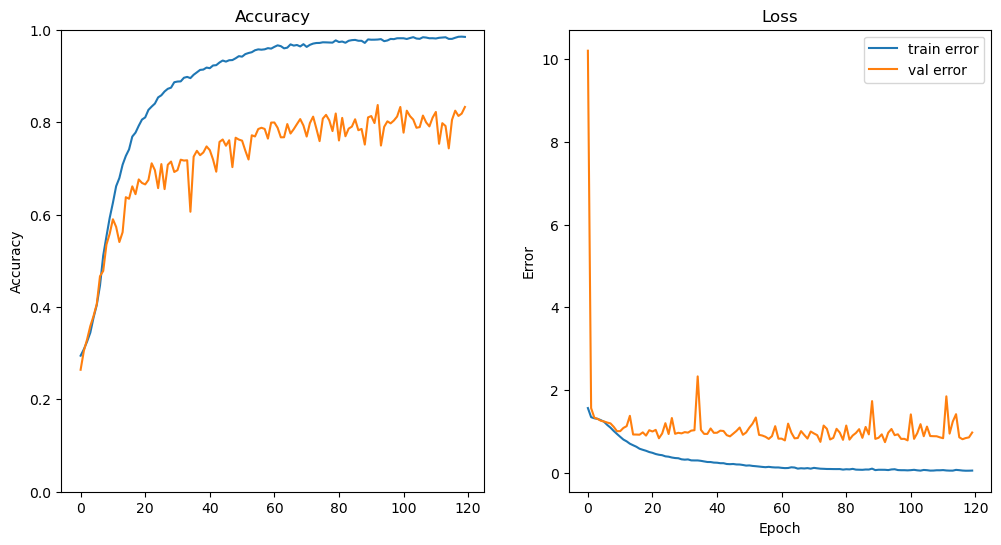

In [36]:
plot_history(history)

## Evaluation

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

247/247 - 2s - loss: 0.9261 - accuracy: 0.8430


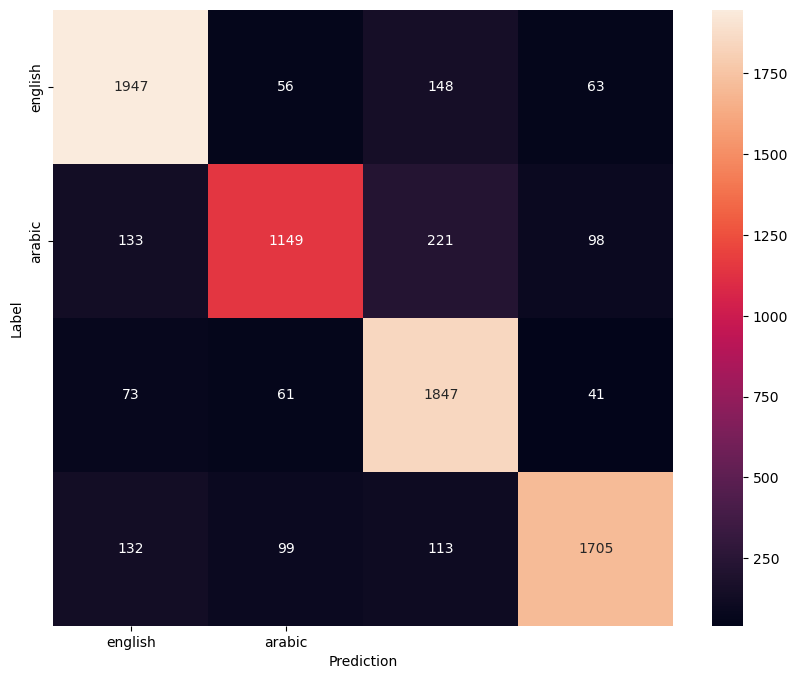

In [35]:
plot_confusion_matrix(model, X_test, languages)